<p><a href="https://colab.research.google.com/github/compgeog/choropleth-tradeoffs/blob/main/explore_choropleth_results.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Choropleth map generation for analysis of choropleth classes


This notebook is used to generate choropleth maps to analyze classes of enumeration units by both humans and computers 

The following cell makes sure the necessary libraries and modules are imported to run the experiments in the rest of this notebook.

In [1]:
from geom.shapex import *
from spatialanalysis.moransi2 import *
from cgl.cgl.util.get_adjacency_matrix import *
from cgl.cgl.util.draw_polygons_shapex import *
from cgl.cgl.util.get_attribute_by_name import *
from cgl.cgl.util.evaluate_all import *
from cgl.cgl.util.pareto_ranking import *
from cgl.cgl.util.parallel_coordinates import *
from cgl.cgl.util.xcolorbrewer import *
from cgl.cgl.util.breakpoints2 import *

import time
import random
# random.seed(10)
import numpy as np
import pickle
import math

import urllib.request as request

import json

import matplotlib.pyplot as plt
%matplotlib inline


# Map Data

In this tutorial, we use the data of 1959 Illinois farm products. This data set has been used in many cartographic studies such as [this](https://www.tandfonline.com/doi/full/10.1111/1467-8306.9303005). The data is converted to a GeoJSON file and can be loaded directly from its [github source](https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/data/il/il.geojson).

In [2]:
# url_il_data = 'https://raw.githubusercontent.com/gisalgs/data/master/OH_geog.geojson'
# with request.urlopen(url_il_data) as response:
#     shp = json.loads(response.read())

baseMapPath = r'C:\Users\jiali\Desktop\choroplethClassAnalysis\mapGeneration\baseMaps'
f = open(baseMapPath + '\\' + 'uscnty48area_102008.geojson')
shp = json.load(f)

all_features = shp['features']
print(len(all_features))
baseMap = 'us'

3109


In [3]:
all_features[0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [4]:
all_features[0]['properties'].keys()

dict_keys(['NAME', 'STATE_NAME', 'FIPS', 'UrbanPop', 'Area', 'AreaKM2', 'GEO_ID', 'PopDensity'])

We need to get the bounds of the coordinates for each enumeration unit:

In [5]:
envelopes = get_feature_envelopes(all_features) # list of [xmin, ymin, xmax, ymax]
# geom_bounds = [min([p[0] for p in envelopes]), min([p[1] for p in envelopes]), max([p[2] for p in envelopes]), max([p[3] for p in envelopes])]
geom_bounds = {
    'xmin': min([p[0] for p in envelopes]), 
    'ymin': min([p[1] for p in envelopes]), 
    'xmax': max([p[2] for p in envelopes]), 
    'ymax': max([p[3] for p in envelopes])
}

geom_bounds # [xmin, ymin, xmax, ymax]

{'xmin': -2235809.497613872,
 'ymin': -1643544.949341902,
 'xmax': 2125197.68616152,
 'ymax': 1322159.8643133966}

Let's quickly draw a map to make sure the geometries are loaded correctly.

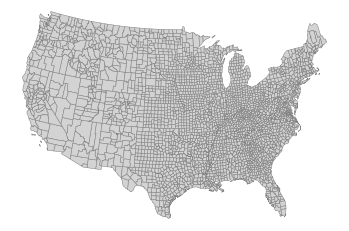

In [6]:
draw_shape(all_features)
plt.axis('off')
plt.axis('equal')
plt.show()

With the data loaded, we need to obtain the adjacency matrix (list), all the values of the attribute synthesized by us, and all the unique values (sorted). 

In [7]:
# adjacent list for the enumration units
adjacency_list = adjacency_matrix(all_features, output='L')
adjacency_list

[[3, 2],
 [5, 2],
 [5, 4],
 [6, 2],
 [6, 4],
 [6, 5],
 [7, 3],
 [8, 3],
 [9, 3],
 [9, 7],
 [10, 3],
 [10, 8],
 [10, 9],
 [11, 9],
 [11, 10],
 [12, 11],
 [13, 12],
 [14, 12],
 [14, 13],
 [15, 14],
 [16, 14],
 [16, 15],
 [17, 16],
 [21, 4],
 [21, 5],
 [23, 22],
 [25, 19],
 [25, 23],
 [25, 24],
 [26, 19],
 [26, 23],
 [26, 25],
 [27, 26],
 [28, 20],
 [28, 27],
 [29, 21],
 [30, 20],
 [30, 21],
 [30, 28],
 [30, 29],
 [31, 21],
 [31, 29],
 [31, 30],
 [32, 4],
 [32, 21],
 [32, 31],
 [34, 33],
 [35, 33],
 [36, 34],
 [38, 37],
 [40, 39],
 [41, 40],
 [42, 36],
 [42, 37],
 [43, 42],
 [44, 43],
 [45, 19],
 [45, 20],
 [45, 26],
 [45, 27],
 [45, 28],
 [46, 44],
 [47, 0],
 [50, 31],
 [50, 32],
 [50, 48],
 [51, 35],
 [53, 43],
 [53, 44],
 [53, 52],
 [54, 45],
 [54, 51],
 [55, 51],
 [55, 52],
 [57, 56],
 [58, 56],
 [59, 30],
 [59, 31],
 [59, 50],
 [60, 51],
 [60, 54],
 [60, 55],
 [60, 56],
 [60, 57],
 [61, 20],
 [61, 45],
 [61, 54],
 [61, 59],
 [62, 20],
 [62, 30],
 [62, 59],
 [62, 61],
 [63, 48],
 [63,

Specify the parameters to synthesize maps besides base map, including color scheme, number of classes

In [8]:
numclass = 4
colorScheme = 'Blues'
# colorScheme = 'RdBu'

#### 1. Generate spatial data (all values) with negative spatial autocorrelation for the enumeration units

##### (1) Use checker board with full negative spatial autocorrelation to overlap with the base map (doesn't work to synthesize data with significant negative spatial autocorrelation)

In [ ]:
# power = 6
# size = 2**power + 1
# size = 8
# negAutoCorMatrix = np.zeros(shape=(size, size))
# size

In [ ]:
# for i in range(size):
#     for j in range(size):
#         if (i + j) % 2 == 0:
#             x = random.uniform(0.5, 1)
#         else:
#             x = random.uniform(0, 0.5)
#         negAutoCorMatrix[i][j] = x
# H_scaled = negAutoCorMatrix
# plt.imshow(H_scaled, interpolation='none')
# plt.colorbar(orientation='vertical')
# plt.show()

##### (2) Use BFS to synthesize data for units and adjacent units to make sure they are not in the same class  

In [ ]:
# find units adjacent to target unit
def getAdjacentUnits(adjacency_list, targetID):
    adjUnitList = []
    for pair in adjacency_list:
        if pair[0] == targetID:
            adjUnitList.append(pair[1])
        elif pair[1] == targetID:
            adjUnitList.append(pair[0])
    return adjUnitList

Initialize all_values with the same size of all_features, and assign small value to the first value in all_values

In [ ]:
all_values = [-1 for i in range(len(all_features))] # initialize all_values with the same size of all_features
all_values[0] = random.uniform(0.5, 1)
visitedIDs = set()
visitedIDs.add(0)
currentQueue = []
currentQueue.append(0)

Generate data with negative spatial autocorrelation

In [ ]:
while len(currentQueue) != 0:
    i =  currentQueue.pop(0)
    name =  all_features[i]['properties']['NAME']
    geoID =  all_features[i]['properties']['GEO_ID']
    print('name: %s geoID: %s' %(name, geoID))
    adjUnitList = getAdjacentUnits(adjacency_list,i)
    for adjUnit in adjUnitList:
        if adjUnit not in visitedIDs:
            if all_values[i] > 0.5:
                all_values[adjUnit] = random.uniform(0, 0.5)
            else:
                all_values[adjUnit] = random.uniform(0.5, 1)
            visitedIDs.add(adjUnit)
            currentQueue.append(adjUnit)
for i in range(len(all_values)):
    if all_values[i] == -1:
        all_values[i] = random.uniform(0, 1)
all_values_neg = all_values

In [ ]:
unique_values = list(set(all_values_neg))
m = len(all_values_neg)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

We can also show a histogram of the data.

In [ ]:
plt.hist(all_values_neg)
plt.show()

##### Defining a classification

A Python class called `Intervals` is defined in the [classify.py](https://github.com/compgeog/cgl/blob/master/cgl/util/classify.py) that will be cloned here (see the beginning of this tutorial). There are multiple ways to create a classification. Below is an example using a set of lower and upper bounds:

In [9]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

We can draw a choropleth map using the classification scheme created from the above section. 

We first need to calculate the geometry bounds of the map, which will be used later.

In [ ]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

We draw the map using the intervals stored in `intervals`:

In [ ]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_neg]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/8  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()


Calculate gobal Moran's I for the data with the base map

In [ ]:
classes = [intervals.get_class(v) for v in all_values_neg]

In [ ]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_neg[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_neg, adjacency_list)

In [10]:
dataGenerationPath = r'C:\Users\jiali\Desktop\choroplethClassAnalysis\mapGeneration\code'

In [ ]:

with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_neg.pickle', 'wb') as f:
    pickle.dump(all_values_neg,f)

#### 2. Generate spatial data (all values) with NO spatial autocorrelation for the enumeration units

In [ ]:
# randomly select values for nonpattern maps
all_values_nonAuto = [random.uniform(0, 1) for i in range(len(all_features))] 

In [ ]:
unique_values = list(set(all_values_nonAuto))
m = len(all_values_nonAuto)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

In [ ]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

In [ ]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

In [ ]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_nonAuto]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [ ]:
classes = [intervals.get_class(v) for v in all_values_nonAuto]

In [ ]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_nonAuto[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_nonAuto, adjacency_list)

In [ ]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_nonAuto.pickle', 'wb') as f:
    pickle.dump(all_values_nonAuto,f)

#### 3. Generate spatial data (all values) with POSITIVE spatial autocorrelation for the enumeration units

We use midpoint displacement interpolation to generate a grid with some trend to synthesize data with positive spatial autocorrelation.

The next a couple of cells are the functions needed for this section

In [11]:
def f(delta, x):
    return sum(x)/len(x)+delta*random.gauss(0,1)

def midpoint2d(maxlevel, sigma, H, addition=False):
    N = int(math.pow(2, maxlevel))
    X = [ [0]*(N+1) for x in range(N+1)]
    delta = sigma
    X[0][0] = delta*random.gauss(0,1)
    X[0][N] = delta*random.gauss(0,1)
    X[N][0] = delta*random.gauss(0,1)
    X[N][N] = delta*random.gauss(0,1)
    D = N
    d = int(N/2)
    for stage in range(1, maxlevel+1):
        delta = delta*math.pow(0.5, 0.5*H)
        for x in range(d, N-d+1, D):
            for y in range(d, N-d+1, D):
                X[x][y] = f(delta, [X[x+d][y+d], X[x+d][y-d],
                                    X[x-d][y+d], X[x-d][y-d]])
        if addition is True:
            for x in range(0, N+1, D):
                for y in range(0, N+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
        delta = delta*math.pow(0.5, 0.5*H)
        for x in range(d, N-d+1, D):
            X[x][0] = f(delta,[X[x+d][0],X[x-d][0],X[x][d]])
            X[x][N] = f(delta,[X[x+d][N],X[x-d][N],X[x][N-d]])
            X[0][x] = f(delta,[X[0][x+d],X[0][x-d],X[d][x]])
            X[N][x] = f(delta,[X[N][x+d],X[N][x-d],X[N-d][x]])
        for x in range(d, N-d+1, D):
            for y in range(D, N-d+1, D):
                X[x][y] = f(delta, [X[x][y+d], X[x][y-d],
                                    X[x+d][y], X[x+d][y]])
        for x in range(D, N-d+1, D):
            for y in range(d, N-d+1, D):
                X[x][y] = f(delta, [X[x][y+d], X[x+d][y-d],
                                    X[x+d][y], X[x-d][y]])
        if addition is True:
            for x in range(0, N+1, D):
                for y in range(0, N+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
            for x in range(d, N-d+1, D):
                for y in range(d, N-d+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
        D = int(D/2)
        d = int(d/2)
    return X

In [12]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [13]:
def getValueUnit(envelopes, generatedMatrix, geom_bounds):
    # get generated data for each enumeration unit in the map
    # envelopes are for each unit, generatedMatrix is the generated matrix
    # return a list of value for each unit
    valueListUnit = []
    boundXMin = geom_bounds['xmin']
    boundXMax = geom_bounds['xmax']
    boundXRange = boundXMax - boundXMin
    boundYMin = geom_bounds['ymin']
    boundYMax = geom_bounds['ymax']
    boundYRange = boundYMax - boundYMin
       
    for envelope in envelopes:
        xMid = (envelope[0] + envelope[2])/2
        yMid = (envelope[1] + envelope[3])/2
        
        xIndex = int((xMid - boundXMin) / boundXRange * generatedMatrix.shape[0]) - 1 
        if xIndex < 0:
            xIndex = 0
        yIndex = int((yMid - boundYMin) / boundYRange * generatedMatrix.shape[0]) - 1 
        if yIndex < 0:
            yIndex = 0
        value = generatedMatrix[yIndex][xIndex]
        valueListUnit.append(value)
    return valueListUnit

##### (1) large positive spatial autocorrelation

Conduct midpoint displacement interpolation

In [ ]:
maxlevel = 8
sigma = 0.5
H = 0.5
if len(sys.argv) == 4:
    maxlevel = string.atoi(sys.argv[1])
    sigma = string.atof(sys.argv[2])
    H = string.atof(sys.argv[3])
X = midpoint2d(maxlevel, sigma, H)

In [ ]:
generatedMatrix = np.array(X)
generatedMatrixNorm = NormalizeData(generatedMatrix)

Visualize generated matrix with some trend

In [ ]:
plt.imshow(generatedMatrixNorm, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
# get value from generated data with MidPoint2.py
all_values_pos_large = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values

In [ ]:
unique_values = list(set(all_values_pos_large))
m = len(all_values_pos_large)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

In [ ]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

In [ ]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

In [ ]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_large]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [ ]:
classes = [intervals.get_class(v) for v in all_values_pos_large]

In [ ]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values_pos_large[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_large, adjacency_list)

In [ ]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_pos_large.pickle', 'wb') as f:
    pickle.dump(all_values_pos_large,f)

##### (2) small positive spatial autocorrelation

In [23]:
maxlevel = 12
sigma = 0.1
H = 0.1
if len(sys.argv) == 4:
    maxlevel = string.atoi(sys.argv[1])
    sigma = string.atof(sys.argv[2])
    H = string.atof(sys.argv[3])
X = midpoint2d(maxlevel, sigma, H)

In [24]:
generatedMatrix = np.array(X)
generatedMatrixNorm = NormalizeData(generatedMatrix)

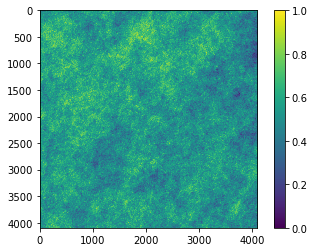

In [25]:
plt.imshow(generatedMatrixNorm, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [26]:
# get value from generated data with MidPoint2.py
all_values_pos_small = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values

In [27]:
unique_values = list(set(all_values_pos_small))
m = len(all_values_pos_small)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

3109 3109 0.22672875657271283 0.851694407224588


[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [28]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

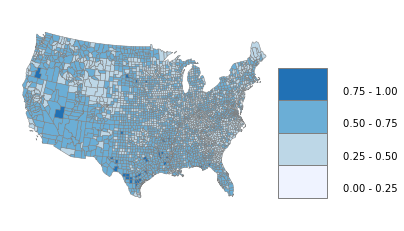

In [29]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_small]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [30]:
classes = [intervals.get_class(v) for v in all_values_pos_small]

In [31]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_small, adjacency_list)

0.45103197520594795

In [32]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_pos_small.pickle', 'wb') as f:
    pickle.dump(all_values_pos_small,f)